<a href="https://colab.research.google.com/github/AliMostafaRadwan/BERT_for_QA/blob/main/Copy_of_main_TS_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:


pd.set_option('display.max_rows', None)

# data = load_WikiLingua("/content/drive/MyDrive/arabic.pkl")

# data = pd.DataFrame(data["data"])

data = pd.read_csv('/content/drive/MyDrive/WikiLingua_cleaned_less_than_max.csv')

data.tail()


,idx,document,summary
20898,9991_1,معظم اقلام الابينفرين بها نافذه تسمح لك بمشاه...,حافظ علي قلم الابينفرين في علبته الي ان تحتاجه...
20899,9991_2,قد تحدث الحساسيه المفرطه حينما يتعرض الشخص بال...,تعرف علي اعراض الحساسيه المفرطه اسال الشخص ان ...
20900,9993_1,قد تصبح لديك مناطق من الماء الاسن اذا تشكلت كت...,قم بتحسين الدوره للتعامل مع مع البقع الصغيره م...
20901,9993_2,يجب الا تنمو الطحالب اذا بقيت مطلعا علي كيميا...,حافظ علي ماء حمام السباحه اضف مبيد الطحالب كو...
20902,9994_2,عندما يصل الطبق الي طاولتك دون ملاحظتك عن مظهر...,لاحظ طريقه تقديم الطبق استمتع باول قضمات اكتب ...


### Read Data

### Preprocessing Data

In [4]:
data = data[['document', 'summary']]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20903 entries, 0 to 20902
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  20903 non-null  object
 1   summary   20903 non-null  object
dtypes: object(2)
memory usage: 326.7+ KB


Removing rows with null

In [6]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20903 entries, 0 to 20902
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  20903 non-null  object
 1   summary   20903 non-null  object
dtypes: object(2)
memory usage: 326.7+ KB


Removing duplicate rows

In [7]:
sum(data.duplicated())

1

In [8]:
data = data.drop_duplicates(subset=['document', 'summary'], keep='last')
sum(data.duplicated())

0

In [9]:
data.shape

(20902, 2)

In [10]:
df=data.copy()

In [11]:
df = df.iloc[:29000,:]

In [12]:
texts = df.document.values.tolist()
summaries = df.summary.values.tolist()

Letter normalization

In [13]:
def normalize(text):
  text = re.sub("[إأآا]", "ا", text)
  text = re.sub("ى", "ي", text)
  text = re.sub("ؤ", "ء", text)
  text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", text)
  text = re.sub("گ", "ك", text)
  return text

In [14]:
texts = [normalize(t) for t in texts]
summaries = [normalize(t) for t in summaries]

Removing stop words from data

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stopwords_list = stopwords.words('arabic')

In [17]:
# stopwords_list

In [18]:
def remove_wstop(text):
  new_text = []
  for t in text.split():
    if t not in stopwords_list:
      new_text.append(t)

  return ' '.join(new_text)


In [19]:
texts = [remove_wstop(t) for t in texts]
summaries = [remove_wstop(t) for t in summaries]

Removing any unwanted
characters

In [20]:
import re
def remove_char(text):
  text = re.sub('([@A-Za-z0-9_]+)|[^\w\s]|#|http\S+', '', text) # cleaning up
  return text

In [21]:
texts = [remove_char(t) for t in texts]
summaries = [remove_char(t) for t in summaries]

In [22]:
texts[0]

'نظرا لان السبب الرءيسي لضغط العين ان ثقافه اليوم تفرض قضاء الوقت امام جهاز الكمبيوتر او التلفاز او الهاتف المحمول او اي جهاز اخر بشاشه فلابد العثور علي بداءل قراءه كتاب ورقي بدلا القراءه علي جهاز لوحي لتقليل الاثار الضاره الناتجه الوقت الممضي امام الشاشه يمكن تجنبه الحال جهاز الكمبيوتر العمل حاول وضع الشاشه مستوي منخفض واستخدام شاشه مضاده للتوهج لتقليل الضغط علي عينيك اذا كنت تعاني اجهاد العين المستمر يزعجك حياتك اليوميه استشر طبيبك المحتمل ان تكون لديك مشكله الرءيه او حاله اخري تسهم عدم الراحه او ضغط العين تشعر الوقايه داءما خير العلاج لذا احرص علي زياره الطبيب لعدم تفاقم المشكله وكذلك الحصول علي العلاج الطبي المناسب اذا لزم الامر'

Applying AraBERT Preprocess on data

In [23]:
!pip install arabert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 19.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186458 sha256=023b4377540342fb379215bb9b999056690f88d3732cc548c8cfbccb158a953a
  Stored in directory: /root/.cache/pip/wheels/10/f0/fd/4813b1177405693e8da9cdea839f0fb64fde161380e058c827
Successfully built emoji


In [24]:
from arabert import ArabertPreprocessor
model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=model_name)

texts = [arabert_prep.preprocess(t) for t in texts]
summaries = [arabert_prep.preprocess(t) for t in summaries]

/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farasa-api.qcri.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


100%|██████████| 241M/241M [00:27<00:00, 8.86MiB/s]


[2023-07-01 22:59:13,924 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [25]:
# text = "ولن نبالغ إذا قلنا: إن 'هاتف' أو 'كمبيوتر المكتب' في زمننا هذا ضروري"
# text = arabert_prep.preprocess(text)
# text

In [26]:
def remove_additions(text):
  # text = re.sub('[a-zA-Z]*\+[a-zA-Z]*', "", text) # cleaning up /\b\w*[Yy]\w*\b/g
  text = re.sub('\+\w+\s', '', text) # cleaning up
  text = re.sub('\w+\+\s', '', text) # cleaning up
  return text

In [27]:
# text = remove_additions(text)
# text

In [28]:
texts = [remove_additions(t) for t in texts]
summaries = [remove_additions(t) for t in summaries]

In [29]:
texts[0]

'نظر لان سبب رءيسي ضغط عين ان ثقاف يوم تفرض قضاء وقت امام جهاز كمبيوتر أو تلفاز أو هاتف محمول أو اي جهاز آخر شاش لابد عثور علي داءل قراء كتاب رقي بدل قراءه علي جهاز وحي تقليل آثار ضاره ناتجه وقت ممضي امام شاشه يمكن تجنب حال جهاز كمبيوتر عمل حاول وضع شاشه مستوى منخفض استخدام شاش مضاد توهج تقليل ضغط علي عين اذ تعاني اجهاد عين مستمر يزعجك حيا اليوم استشر طبيب محتمل ان تكون ديك مشكل رءيه أو حال أخرى تسهم عدم راحه أو ضغط عين تشعر وقايه داءم خير علاج لذا أحرص علي زيار طبيب عدم تفاقم مشكله كذلك حصول علي علاج طبي مناسب اذ لزم أمر'

In [30]:
data.iloc[0,0]

'نظرا لان السبب الرءيسي لضغط العين هو ان ثقافه اليوم تفرض قضاء الوقت امام جهاز الكمبيوتر او التلفاز او الهاتف المحمول او اي جهاز اخر بشاشه فلابد من العثور علي بداءل مثل قراءه كتاب ورقي بدلا من القراءه علي جهاز لوحي لتقليل الاثار الضاره الناتجه عن الوقت الممضي امام الشاشه ولا يمكن تجنبه كما هو الحال مع جهاز الكمبيوتر في العمل حاول وضع الشاشه في مستوي منخفض واستخدام شاشه مضاده للتوهج لتقليل الضغط علي عينيك اذا كنت تعاني من اجهاد العين المستمر الذي يزعجك في حياتك اليوميه استشر طبيبك من المحتمل ان تكون لديك مشكله في الرءيه او حاله اخري تسهم في عدم الراحه و او ضغط العين الذي تشعر به الوقايه داءما خير من العلاج لذا احرص علي زياره الطبيب لعدم تفاقم المشكله وكذلك الحصول علي العلاج الطبي المناسب اذا لزم الامر'

Determining the Maximum Permissible Sequence Lengths

In [31]:
txt_len = [len(t.split()) for t in texts]
smy_len = [len(t.split()) for t in summaries]

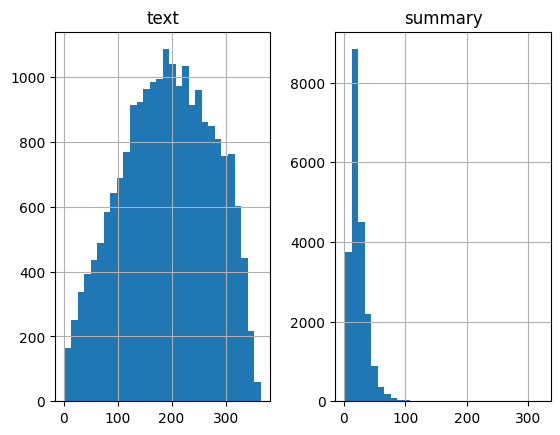

In [32]:
length_df = pd.DataFrame({'text':txt_len, 'summary':smy_len})
length_df.hist(bins = 30)
plt.show()

In [33]:
max(txt_len), max(smy_len)

(365, 321)

In [34]:
max_text_len = 2000
max_summary_len = 128

Select the Summaries and Text which fall below max length

In [35]:

texts = np.array(texts)
summaries= np.array(summaries)

short_text = []
short_summary = []

for i in range(len(texts)):
    if len(summaries[i].split()) <= max_summary_len and len(texts[i].split()) <= max_text_len:
        short_text.append(texts[i])
        short_summary.append(summaries[i])

pre = pd.DataFrame({'text': short_text,'summary': short_summary})

pre.head(2)

,text,summary
0,نظر لان سبب رءيسي ضغط عين ان ثقاف يوم تفرض قضا...,قلل وقت تعرض شاش أذهب الي طبيب
1,أفعل أنت جالس منع نفس نوم اغلق عين أحكام قدر إ...,اغلق عين +ك


In [36]:
pre['summary'] = pre['summary'].apply(lambda x : 'start '+ x + ' end')

Tokenizing the Text

Split the data into train and test data parts.

In [37]:
from sklearn.model_selection import train_test_split
X = pre["text"].values
y = pre["summary"].values

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.1,random_state=0)

Tokenize the text data and get vocabulary size

In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(X))

# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y))

In [39]:
thresh = 5

cnt = 0
tot_cnt = 0

for k, v in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if v < thresh:
        cnt = cnt + 1

print(f"TEXT: Prcentage of rare words in vocabulary: {(cnt / tot_cnt) * 100}")


thresh = 3

y_cnt = 0
y_tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    y_tot_cnt = y_tot_cnt + 1
    if value < thresh:
        y_cnt = y_cnt + 1

print("Summary: Prcentage of rare words in vocabulary:",(y_cnt / y_tot_cnt) * 100)

TEXT: Prcentage of rare words in vocabulary: 59.11330049261084
Summary: Prcentage of rare words in vocabulary: 45.270601033451186


In [40]:
# Prepare a TEXT tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(X))

# Convert text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_train)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = len(x_tokenizer.word_index) + 1

print(f"Size of vocabulary in X = {x_voc}")

Size of vocabulary in X = 47909


In [41]:
# Prepare a SUMMAARY tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=y_tot_cnt-y_cnt)
y_tokenizer.fit_on_texts(list(y))

# Convert text sequences to integer sequences
y_tr_seq = y_tokenizer.texts_to_sequences(y_train)
y_val_seq = y_tokenizer.texts_to_sequences(y_val)

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
y_voc = len(y_tokenizer.word_index) + 1

print(f"Size of vocabulary in Y = {y_voc}")

Size of vocabulary in Y = 18386


skip_gram embedding

In [42]:
corpus_X = [t.split() for t in X]
corpus_y = [t.split() for t in y]

In [43]:
import dataclasses
import gensim
dim = 150
window = 10
word2vec_x = gensim.models.Word2Vec(corpus_X, min_count=1, vector_size=dim, window=window, sg=1)

In [44]:
dim = 150
window = 10
word2vec_y = gensim.models.Word2Vec(corpus_y, min_count=1, vector_size=dim,window=window, sg=1)

In [45]:
# word2vec_x.wv.get_vector('مباراه')

In [46]:
# load the whole embedding into memory
x_w2v_embeddings_index = {}
for word in word2vec_x.wv.index_to_key:
    x_w2v_embeddings_index[word] = word2vec_x.wv[word]
print('Loaded %s word vectors.' % len(x_w2v_embeddings_index))


Loaded 47916 word vectors.


In [47]:
# create a weight matrix for words in training docs

x_embedding_matrix = np.zeros((x_voc, dim))
for word, i in x_tokenizer.word_index.items():
    # print(i, word)
    embedding_vector = x_w2v_embeddings_index.get(word)
    if embedding_vector is not None:
        x_embedding_matrix[i] = embedding_vector

print('Embedding Matrix shape:', x_embedding_matrix.shape)

Embedding Matrix shape: (47909, 150)


In [48]:
# load the whole embedding into memory
y_w2v_embeddings_index = {}
for word in word2vec_y.wv.index_to_key:
    y_w2v_embeddings_index[word] = word2vec_y.wv[word]
print('Loaded %s word vectors.' % len(y_w2v_embeddings_index))


Loaded 18387 word vectors.


In [49]:
# create a weight matrix for words in training docs
y_embedding_matrix = np.zeros((y_voc, dim))
for word, i in y_tokenizer.word_index.items():
    # print(i, word)
    embedding_vector = y_w2v_embeddings_index.get(word)
    if embedding_vector is not None:
        y_embedding_matrix[i] = embedding_vector

print('Embedding Matrix shape:', y_embedding_matrix.shape)

Embedding Matrix shape: (18386, 150)


### Define the encoder decoder model

###### 1. First we define Attension layer

In [50]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        # logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        # logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """

            # logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            # logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            # logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            # logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            # logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            # logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

###### 2. Define the model

In [51]:

latent_dim = 150
embedding_dim=150
# Encoder
encoder_inputs = Input(shape=(max_text_len,), name='Encoder_Input')
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim, weights=[x_embedding_matrix],
                      trainable=False, name='Encoder_Embedding')(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,
                      return_state=True,dropout=0.4,
                      name='Encoder_LSTM1')

print(enc_emb)
print(type(enc_emb))

encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,
                      dropout=0.4, name='Encoder_LSTM2')
encoder_outputs, state_h, state_c = encoder_lstm2(encoder_output1)
#encoder lstm 3
# encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,
#                    dropout=0.4, name='Encoder_LSTM3')
# encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,), name='Decoder_Input')
#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim, weights=[y_embedding_matrix],
                      trainable=False, name='Decoder_Embedding')
dec_emb = dec_emb_layer(decoder_inputs)
#decoder lstm
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,
                    dropout=0.4, name='Decoder_LSTM')
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])
# Attention layer
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])
# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)


KerasTensor(type_spec=TensorSpec(shape=(None, 2000, 150), dtype=tf.float32, name=None), name='Encoder_Embedding/embedding_lookup/Identity_1:0', description="created by layer 'Encoder_Embedding'")
<class 'keras.engine.keras_tensor.KerasTensor'>


Training the Model

In [52]:

import tensorflow as tf

print(tf.test.is_gpu_available())

print(tf.test.is_gpu_available(cuda_only=True))


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False
False


In [53]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

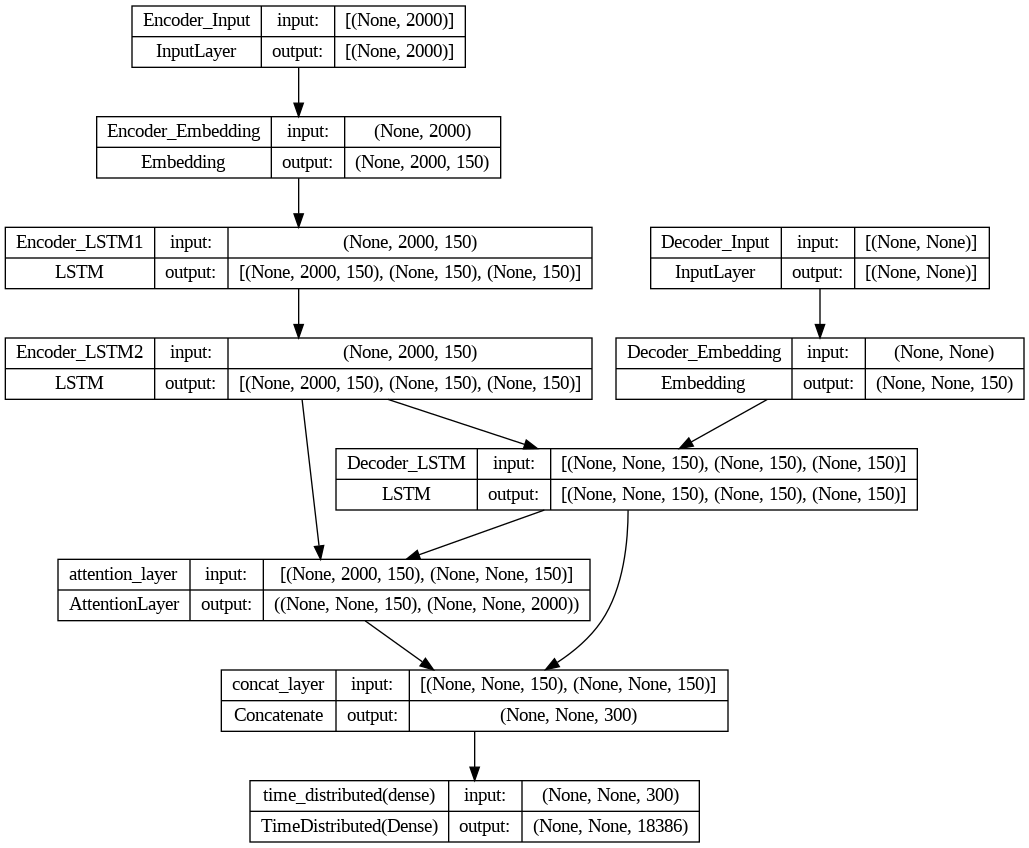

In [54]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [55]:
# model.summary()

In [ ]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=50,
    callbacks=[es],
    batch_size=15,
    validation_data=([x_val, y_val[:, :-1]],
                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:
                     , 1:]),
    )

Epoch 1/50
   3/1254 [..............................] - ETA: 7:22:46 - loss: 9.8020

In [ ]:
#plot results
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 12))
plt.rcParams['figure.figsize'] = [16, 16]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Text Summarization \nTraining and Validation Loss Over Epochs')

#loss

Generating Predictions

In [ ]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [ ]:
reverse_source_word_index[0]='PAD'
reverse_target_word_index[0]='PAD'

In [ ]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c], verbose=0)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_summary_len-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    decoded_sentence = decoded_sentence.replace('PAD', '')
    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
pred_summaries = [decode_sequence(x.reshape(1,max_text_len)) for x in x_val]
true_summaries = [seq2summary(x) for x in y_val ]

In [ ]:
for i in range(0, 5):
    print ('Text:', seq2text(x_val[i]))
    print ('Original summary:', seq2summary(y_val[i]))
    print ('Predicted summary:', decode_sequence(x_val[i].reshape(1,max_text_len)))
    print()

In [ ]:
pred_summaries = [t.strip() for t in pred_summaries]
pred_summaries = [t for t in pred_summaries if t!="" or t!= " "]

In [ ]:
true_summaries = [t.strip() for t in true_summaries]
true_summaries = [t for t in true_summaries if t!="" or t!= " "]

In [ ]:
refs, hyps = [], []
for t1, t2 in zip(true_summaries, pred_summaries):
  if t1=="":
    pass
  elif t2=="":
    pass
  elif t2==" ":
    pass
  else:
    refs.append(t1)
    hyps.append(t2)

In [ ]:
from rouge import Rouge

rouge = Rouge()
scores = rouge.get_scores(hyps, refs, avg=True)
scores

In [ ]:
import session_info
session_info.show()
